# Localizer Behavioral Data & Onset Generation

In [19]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import os

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
# %load_ext rpy2.ipython
# %R require(lme4)
# %R require(lmerTest)

## Gather experiment info

In [20]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data/')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')

In [21]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info

,subid,group,remove
1,2,control,NaN
2,3,control,NaN
3,4,control,NaN
4,5,control,NaN
5,6,control,NaN
6,7,control,NaN
7,9,control,NaN
8,10,control,NaN
9,11,control,NaN


## Load in data

In [22]:
dl = pd.DataFrame()

for subid in subj_info.subid:
    print subid
    
    # add study file
    study_file = op.join(dirs['datadir'], str(subid), str(subid) + '_behav_localizer.csv')
    d = pd.read_csv(study_file)
    d['subid'] = subid
    dl = dl.append(d, ignore_index=True)
    
# Merge with subj_info
dl = dl.merge(subj_info, on='subid', how='outer')

2
3
4
5
6
7
9
10
11


In [23]:
dl.head()

,index,run,trial,onset,duration,cond,rep,resp,acc,respRT,ISIresp,ISIacc,ISIrespRT,subid,group,remove
0,1,1,1,12.0046,1.5966,fruitveg,0,NR,0,999.0000,0,1,0.1215,2,control,NaN
1,2,1,2,13.6030,1.5974,fruitveg,0,NR,0,0.3843,NR,0,999.0000,2,control,NaN
2,3,1,3,15.2006,1.5995,fruitveg,0,0,1,0.5053,NR,0,0.1906,2,control,NaN
3,4,1,4,16.8003,1.6003,fruitveg,1,1,1,0.4378,NR,0,0.5899,2,control,NaN
4,5,1,5,18.4009,1.6005,fruitveg,0,0,1,0.3235,NR,0,999.0000,2,control,NaN


In [24]:
dl.groupby(['subid', 'group']).mean().reset_index().groupby('group').count().subid

group
control    9
Name: subid, dtype: int64

### Deal with no responses (NR): Set ISI resp as resp

In [25]:
dl.respRT[dl.resp == 'NR'] = dl.ISIrespRT[dl.resp == 'NR'] + .6 # adjust for stimTime
dl.acc[dl.resp == 'NR'] = dl.ISIacc[dl.resp == 'NR']
dl.resp[dl.resp == 'NR'] = dl.ISIresp[dl.resp == 'NR']

drop_cols = ['ISIrespRT', 'ISIresp', 'ISIacc', 'remove', 'index']
dl.drop(drop_cols, 1, inplace=True)

# Correct duration of image trials by subtracting ITI (1s fix)
dl['duration_adj'] = dl.duration
dl.ix[dl.cond != 'rest', 'duration_adj'] = dl.ix[dl.cond != 'rest', 'duration_adj'] - 1 # subtract ITI

/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [26]:
dl.head()

,run,trial,onset,duration,cond,rep,resp,acc,respRT,subid,group,duration_adj
0,1,1,12.0046,1.5966,fruitveg,0,0,1,0.7215,2,control,0.5966
1,1,2,13.6030,1.5974,fruitveg,0,NR,0,999.6000,2,control,0.5974
2,1,3,15.2006,1.5995,fruitveg,0,0,1,0.5053,2,control,0.5995
3,1,4,16.8003,1.6003,fruitveg,1,1,1,0.4378,2,control,0.6003
4,1,5,18.4009,1.6005,fruitveg,0,0,1,0.3235,2,control,0.6005


### Remove time for lead-in (12 s)

In [27]:
dl['onset_adj'] = dl.onset - 12
dl.head()

,run,trial,onset,duration,cond,rep,resp,acc,respRT,subid,group,duration_adj,onset_adj
0,1,1,12.0046,1.5966,fruitveg,0,0,1,0.7215,2,control,0.5966,0.0046
1,1,2,13.6030,1.5974,fruitveg,0,NR,0,999.6000,2,control,0.5974,1.6030
2,1,3,15.2006,1.5995,fruitveg,0,0,1,0.5053,2,control,0.5995,3.2006
3,1,4,16.8003,1.6003,fruitveg,1,1,1,0.4378,2,control,0.6003,4.8003
4,1,5,18.4009,1.6005,fruitveg,0,0,1,0.3235,2,control,0.6005,6.4009


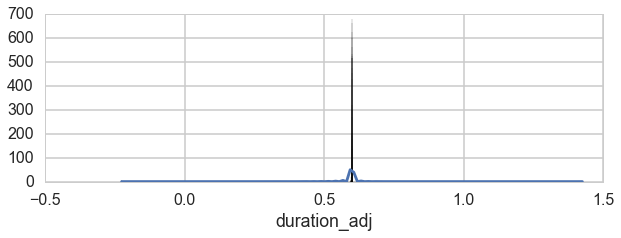

In [28]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(111)
sns.distplot(dl[dl.duration_adj < 5].duration_adj, ax=ax)

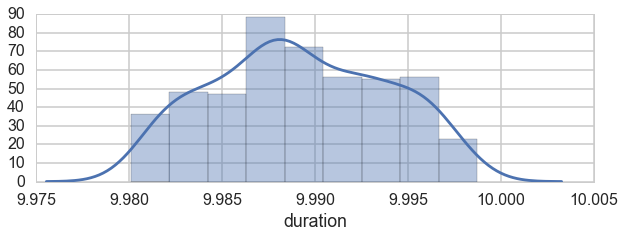

In [29]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(111)
sns.distplot(dl[dl.duration_adj > 5].duration, ax=ax)

## Analyze RTs

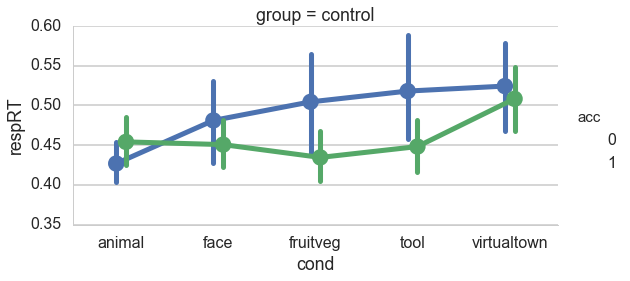

In [30]:
dl_resp = dl[(dl.resp != 'NR') & (dl.cond != 'rest')]
means = dl_resp.groupby(['subid', 'group', 'cond', 'rep', 'acc']).mean().reset_index()

sns.factorplot(x='cond', hue='acc', y='respRT', col='group',
               units='subid', ci=68, dodge=.1,
               data=means, aspect=2)

## Analyze Accuracy

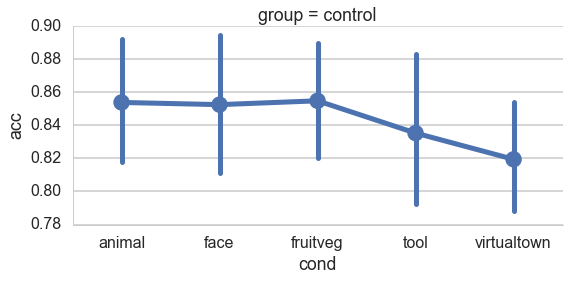

In [31]:
dl_resp = dl[(dl.cond != 'rest')]
means = dl_resp.groupby(['subid', 'group', 'cond', 'rep']).mean().reset_index()

sns.factorplot(x='cond', y='acc', col='group',
               units='subid', ci=68, dodge=.1,
               data=means, aspect=2)

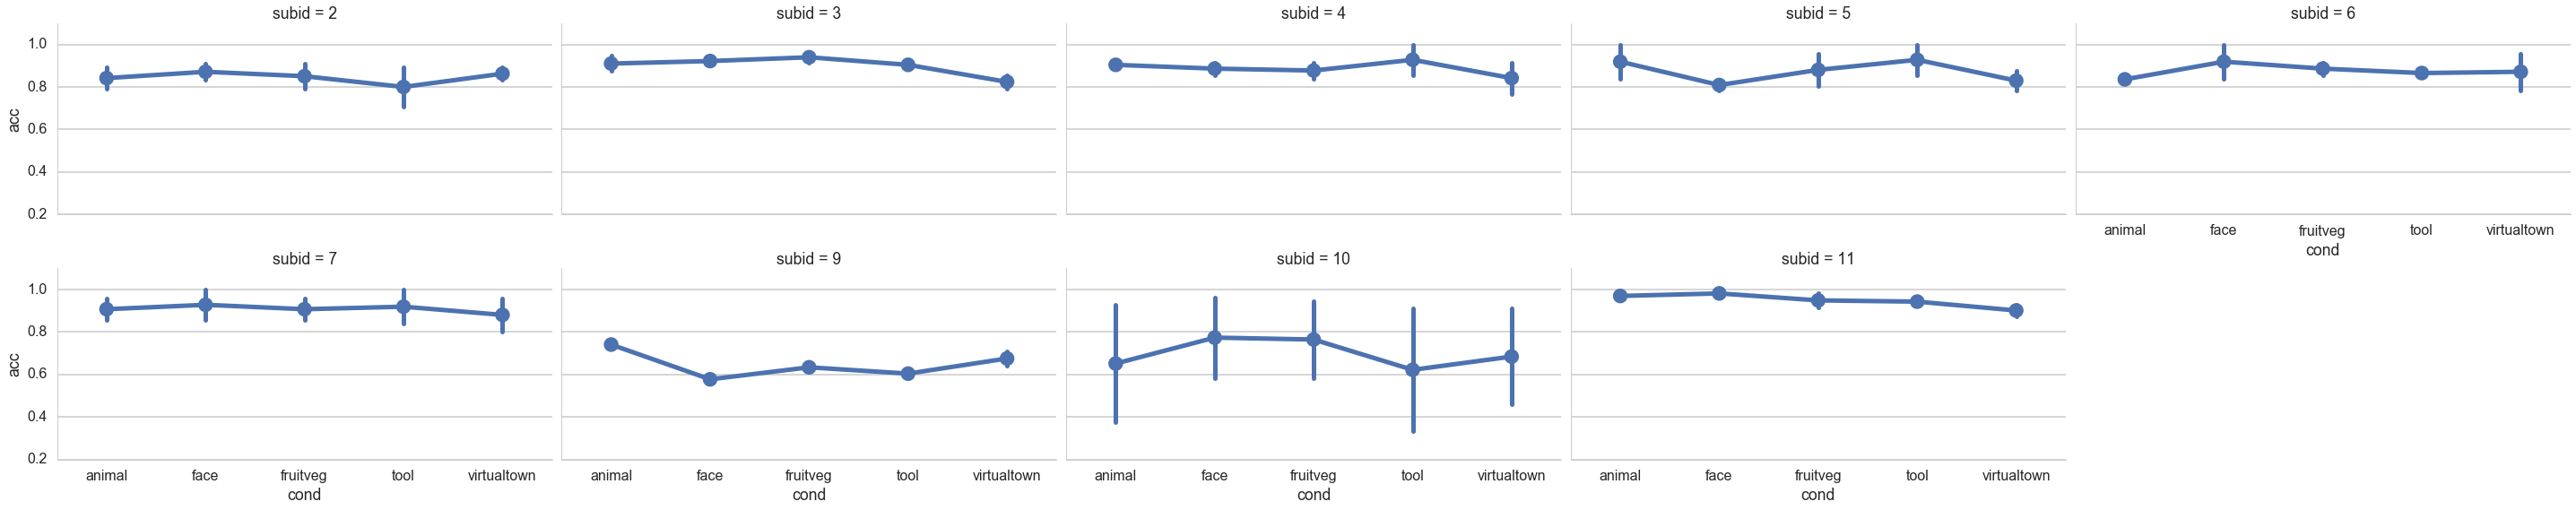

In [36]:
dl_resp = dl[(dl.cond != 'rest')]
means = dl_resp.groupby(['subid', 'group', 'cond', 'rep']).mean().reset_index()

sns.factorplot(x='cond', y='acc', col='subid', col_wrap = 5,
               units='subid', ci=68, dodge=.1,
               data=means, aspect=2)

In [32]:
dl.cond.unique()

array(['fruitveg', 'rest', 'tool', 'face', 'animal', 'virtualtown'], dtype=object)

---

## Generate onset files

Each csv file must have a column for `run`, `condition`, `onset`, `duration`, and `value`

In [33]:
output_filename = 'localizer_cond.csv'
output_dir = '/Volumes/group/awagner/sgagnon/SST/data'

for subid in subj_info.subid:
    print subid
    
    dsub = dl[(dl.subid == subid) & (dl.cond != 'rest')]
    ddesign = pd.DataFrame({'run': dsub.run,
                            'condition': dsub.cond,
                            'onset': dsub.onset_adj,
                            'duration': dsub.duration_adj,
                            'value': 1})
    
    sub_output_dir = op.join(output_dir, 'sst0'+str(subid), 'design')
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

2
3
4
5
6
7
9
10
11


In [35]:
output_filename = 'localizer_cond_mvpa.csv'
output_dir = '/Volumes/group/awagner/sgagnon/SST/data'

# for subid in subj_info.subid:
for subid in subj_info.subid:
    print subid
    dsub = dl[(dl.subid == subid)] # & (dl.cond != 'rest')
    ddesign = pd.DataFrame({'run': dsub.run + 12, #update w/nav runs
                            'condition': dsub.cond,
                            'onset': dsub.onset_adj,
                            'duration': dsub.duration_adj,
                            'value': 1})
    
    ddesign.to_csv(op.join(output_dir, 'sst0'+str(subid),
                           'design', output_filename), index=False)

2
3
4
5
6
7
9
10
11
